In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'DLforCV/assignments/assignment1/'
FOLDERNAME = 'assignment1_problem'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/ai604/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/assignment1_problem/ai604/datasets
/content/drive/My Drive/assignment1_problem


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [ ]:
import random
import numpy as np
from ai604.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
from ai604.features import hog_feature, sift_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'ai604/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a SIFT(Scale-Invariant Feature Transform). We form our final feature vector for each image by concatenating
the HOG and mean of descriptors from SIFT.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the SIFT descriptors show keypoint features based on DoG(Difference of Gaussians). As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `sift` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
from ai604.features import *

feature_fns = [hog_feature, sift_feature]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from ai604.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. If you are careful                   #
# you should be able to get accuracy of above 0.35 on the validation set.      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Reshape the data to (N, D) format
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten (N, D)
X_test_feats = X_test_feats.reshape(X_test_feats.shape[0], -1)  # Flatten (N, D)
X_val = X_val.reshape(X_val.shape[0], -1)  # (1000, 32*32*3) = (1000, 3072)


# Perform grid search over learning rates and regularization strengths
for lr in learning_rates:
    for reg in regularization_strengths:
        # Initialize a new Linear SVM model
        svm = LinearSVM()

        # Train the SVM using the training data
        svm.train(X_train_feats,
                  y_train,
                  learning_rate=lr,
                  reg=reg,
                  batch_size=256,
                  num_iters=3000,
                  verbose=False)

        # Predict on the training and validation data
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)

        # Compute accuracy for both training and validation sets
        train_accuracy = np.mean(y_train_pred == y_train)
        val_accuracy = np.mean(y_val_pred == y_val)

        # Store the results
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # Keep track of the best model based on validation accuracy
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.121000 val accuracy: 0.130000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.105878 val accuracy: 0.098000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.109082 val accuracy: 0.105000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.117143 val accuracy: 0.112000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.095265 val accuracy: 0.101000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.099612 val accuracy: 0.119000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.083673 val accuracy: 0.093000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.101061 val accuracy: 0.084000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.097653 val accuracy: 0.088000
best validation accuracy achieved: 0.130000


In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)  # (49000, 3072)
X_val = X_val.reshape(X_val.shape[0], -1)  # (1000, 3072)
print(f"Shape of X_train: {X_train.shape}")  # Expected: (49000, 3072)
print(f"Shape of X_test_feats: {X_test_feats.shape}")  # Should also be (N, 3072)

Shape of X_train: (49000, 3072)
Shape of X_test_feats: (1000, 273)


In [ ]:
# Retrain the SVM with feature-extracted training data
#best_svm = LinearSVM()
#best_svm.train(X_train_feats, y_train, learning_rate=5e-6, reg=1e5, num_iters=1500, verbose=True)

# Predict on the validation and test sets using the trained model
y_val_pred = best_svm.predict(X_val_feats)
y_test_pred = best_svm.predict(X_test_feats)

# Compute accuracies
val_accuracy = np.mean(y_val == y_val_pred)
test_accuracy = np.mean(y_test == y_test_pred)

print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

Validation accuracy: 0.1300
Test accuracy: 0.1320


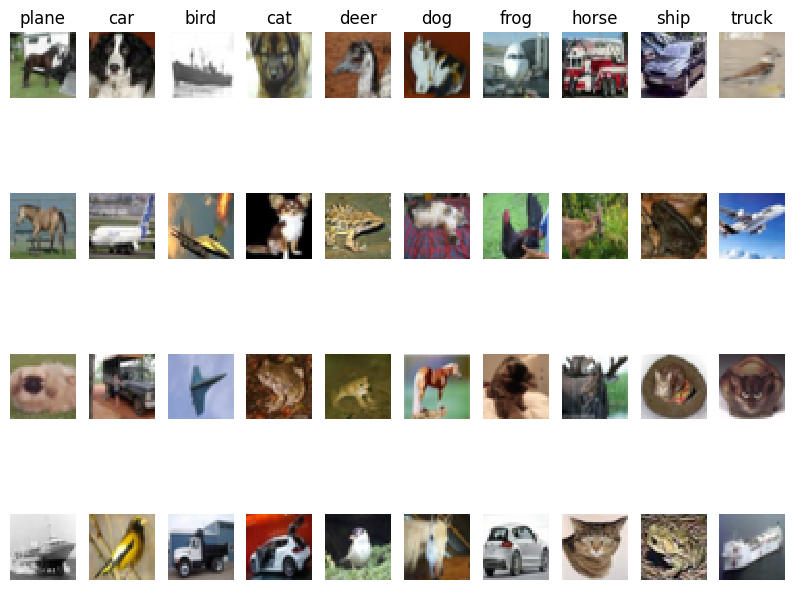

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 4
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ Some of them make sense, like the boat for the plane and the deer for the dog, however, others do not. Like the deer/cat being misinterpreted as a truck does not make any sense.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 273)
(49000, 272)


In [ ]:
from ai604.classifiers.fc_net import TwoLayerNet
from ai604.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = [1e-3, 5e-4, 1e-4]
regularization_strengths = [1e-3, 1e-4, 5e-4]

best_val_acc = -1  # Track the best validation accuracy

for lr in learning_rates:
    for reg in regularization_strengths:
        print(f'Training with lr={lr}, reg={reg}')

        # Initialize a new two-layer neural network
        net = TwoLayerNet(input_dim, hidden_dim, num_classes, weight_scale=1e-2, reg=reg)

        # Set up the solver to train the network
        solver = Solver(net, data,
                        update_rule='adam',
                        optim_config={'learning_rate': lr},
                        lr_decay=0.95,
                        num_epochs=20,
                        batch_size=200,
                        verbose=True)

        # Train the network
        solver.train()

        # Check validation accuracy
        val_acc = solver.best_val_acc

        # Keep track of the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_net = net

print(f'Best validation accuracy achieved: {best_val_acc}')

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Training with lr=0.001, reg=0.001
(Iteration 1 / 4900) loss: 2.311583
(Epoch 0 / 20) train acc: 0.215000; val_acc: 0.187000
(Iteration 11 / 4900) loss: 2.140942
(Iteration 21 / 4900) loss: 1.839156
(Iteration 31 / 4900) loss: 1.795071
(Iteration 41 / 4900) loss: 1.669372
(Iteration 51 / 4900) loss: 1.737081
(Iteration 61 / 4900) loss: 1.537156
(Iteration 71 / 4900) loss: 1.482115
(Iteration 81 / 4900) loss: 1.429524
(Iteration 91 / 4900) loss: 1.437084
(Iteration 101 / 4900) loss: 1.392948
(Iteration 111 / 4900) loss: 1.456512
(Iteration 121 / 4900) loss: 1.399033
(Iteration 131 / 4900) loss: 1.418925
(Iteration 141 / 4900) loss: 1.496459
(Iteration 151 / 4900) loss: 1.429483
(Iteration 161 / 4900) loss: 1.521037
(Iteration 171 / 4900) loss: 1.464692
(Iteration 181 / 4900) loss: 1.519315
(Iteration 191 / 4900) loss: 1.522865
(Iteration 201 / 4900) loss: 1.430969
(Iteration 211 / 4900) loss: 1.468660
(Iteration 221 / 4900) loss: 1.413294
(Iteration 231 / 4900) loss: 1.376144
(Iteration 

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.557
